In [38]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy
import argparse
import random
import numpy as np
import torchnet as tnt
import torch.utils.data as data
from PIL import Image
plt.ion()   # interactive mode

In [124]:
img_size = 224
data_dir = '../../ssl_data_96/unsupervised_split'
batch_size = 16
manual_seed = 9000
cudnn.benchmark = True
num_workers = 4
ngpu = int(0)
is_cuda = False
net_weights_path = '/home/raghavjajodia/Documents/tempdir2/netD_epoch_6.pth'
ndf = 64
lr = 0.001
beta1 = 0.5
top_k = 5

In [85]:
class RotationDataset(Dataset):
    
    def __init__(self, split, root_dir, preTransform=None, postTransform = None):
        self.root_dir = root_dir
        
        #Output of pretransform should be PIL images
        self.preTransform = preTransform
        
        self.postTransform = postTransform
        self.split = split
        self.data_dir = root_dir + '/' + split
        self.dataset = datasets.ImageFolder(self.data_dir, self.preTransform)        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img0,clss = self.dataset[idx]
        
        #Rotate PIL image multiple times
        img1 = img0.rotate(90)
        img2 = img0.rotate(180)
        img3 = img0.rotate(270)
        
        img_list = [img0,img1,img2,img3]
        
        arr4 = np.arange(4)
        np.random.shuffle(arr4)
        img_newList = [img_list[arr4[0]], img_list[arr4[1]], img_list[arr4[2]], img_list[arr4[3]]]
        
        if self.postTransform:
            sampleList = list(map(lambda pilim : self.postTransform(pilim),img_newList))
        else:
            sampleList = list(map(lambda pilim : transforms.ToTensor(pilim),img_newList))
        sample = torch.stack(sampleList)
        rotation_labels = torch.LongTensor(arr4)
        return sample, rotation_labels

In [125]:
data_pre_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
    ]),
}

data_post_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

image_datasets = {x: RotationDataset(x, data_dir, data_pre_transforms[x], data_post_transforms[x])
                  for x in ['train', 'val']}

assert image_datasets

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch_size,
                                              shuffle=True, num_workers=num_workers)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

if torch.cuda.is_available() and not is_cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda:0" if is_cuda else "cpu")

torch.Size([16, 4, 3, 64, 64]) torch.Size([16, 4])
torch.Size([64, 3, 64, 64]) torch.Size([64])
tensor([2, 0, 1, 3, 0, 1, 2, 3, 1, 0, 3, 2, 3, 0, 1, 2, 1, 0, 3, 2, 1, 3, 2, 0,
        1, 0, 3, 2, 1, 3, 0, 2, 3, 2, 1, 0, 0, 2, 3, 1, 0, 1, 2, 3, 3, 0, 2, 1,
        3, 2, 0, 1, 2, 0, 3, 1, 1, 0, 3, 2, 2, 1, 0, 3])


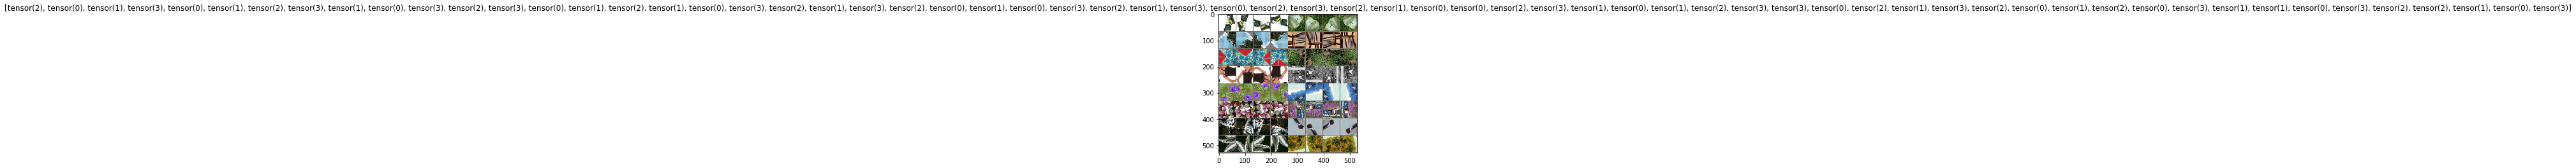

In [121]:
#Code for jupyter notebook
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape)
shapeList = list(inputs.size())[1:]
shapeList[0] = -1
inputs = torch.reshape(inputs, shapeList)
classes = torch.reshape(classes, (-1,))
print(inputs.shape, classes.shape)
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x for x in classes])

In [126]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.

#General Code for supervised train
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            n_samples = 0

            # Iterate over data.
            for batch_num, (inputs, labels) in enumerate(dataloaders[phase]):
                
                #Reshaping the inputs and labels
                shapeList = list(inputs.size())[1:]
                shapeList[0] = -1
                inputs = torch.reshape(inputs, shapeList)
                labels = torch.reshape(labels, (-1,))
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                n_samples += batch_size

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                 # statistics
                running_loss += loss.item() * inputs.size(0)
                pred_top_1 = torch.topk(outputs, k=1, dim=1)[1]
                running_corrects += pred_top_1.eq(labels.view_as(pred_top_1)).int().sum().item()
                
                if batch_num % 100 == 0:
                    # Metrics
                    top_1_acc = running_corrects/n_samples
                    epoch_loss = running_loss / n_samples

                    print('{} Loss: {:.4f} Top 1 Acc: {:.4f} \n'.format(phase, epoch_loss, top_1_acc))
                    
                end = time.time()
                
            # Metrics
            top_1_acc = running_corrects/n_samples
            epoch_loss = running_loss / n_samples

            print('{} Loss: {:.4f} Top 1 Acc: {:.4f} Top k Acc: {:.4f}\n'.format(phase, epoch_loss, top_1_acc))

            # deep copy the model
            if phase == 'val' and top_1_acc > best_acc:
                best_acc = top_1_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), '%s/net_epoch_%d.pth' % (checkpoint_path, epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [127]:
######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [128]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

In [130]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_ft.parameters(), lr=0.001, betas=(beta1, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
trainedModel = train_model(model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4811 Top 1 Acc: 0.2188 

